<a href="https://colab.research.google.com/github/YooSunYoung/AFCompetition/blob/main/1896_baseline_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 정답 제출 가이드는 가장 하단에 있습니다 :)

### 필요한 라이브러리를 설치하고 불러옵니다.

In [ ]:
!pip install simpledbf
!pip install rasterio

In [238]:
# import libraries
import netCDF4
import os
import cv2
import rasterio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from simpledbf import Dbf5

### 샘플 제출 파일을 다운로드 받고 압축을 해제합니다.

In [ ]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/1896/sample_dataset.zip
!unzip sample_dataset.zip

### 입력 값으로 쓰이는 데이터를 열어봅니다.

* train sample에 들어있는 천리안 이미지는 UTC+9 기준 2020년 06월 25일 09 시 관측 데이터입니다.

* GPM의 경우 UTC 기준 2020년 06월 25일 00 시, UTC+9 기준 2020년 06월 25일 09시 관측 데이터 입니다.

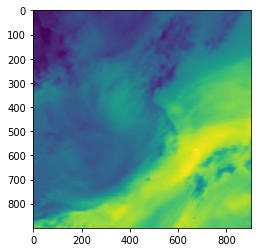

In [223]:
# load TPW
train_tpw_dir = './sample_dataset/train/input_cheonlian-2A/TPW/'
tpw_files = os.listdir(train_tpw_dir)
tpw_file = [x for x in tpw_files if x.endswith('.nc')][0]  # load 1 sample image.
tpw_file_path = os.path.join(train_tpw_dir, tpw_file)
nc = netCDF4.Dataset(tpw_file_path, mode='r')
tpw_sample = nc.variables['TPW'][:]
plt.imshow(tpw_sample.astype('int'))

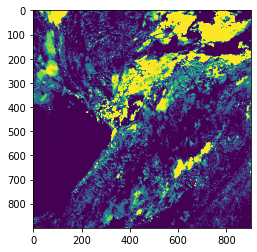

In [222]:
# load RR
train_rr_dir = './sample_dataset/train/input_cheonlian-2A/RR/'
rr_files = os.listdir(train_rr_dir)
rr_file = [x for x in rr_files if x.endswith('.nc')][0]  # load 1 sample image.
rr_file_path = os.path.join(train_rr_dir, rr_file)
nc = netCDF4.Dataset(rr_file_path, mode='r')
rr_sample = nc.variables['RR'][:]
plt.imshow(rr_sample.astype('int')*100, vmin=0, vmax=255)

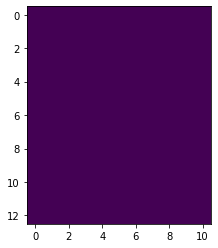

In [248]:
# load GPM
train_gpm_dir = './sample_dataset/train/input_nasa_gpm/'
gpm_files = os.listdir(train_gpm_dir)
gpm_files = [x for x in gpm_files if x.endswith('.tif')][:2]  # load 2 sample images which is 1 hour or records
sample_gpm = np.zeros((13, 11))
for gpm_file in gpm_files:
  gpm_file_path = os.path.join(train_gpm_dir, gpm_file)
  with rasterio.open(gpm_file_path) as img :
    sample_gpm += np.reshape(img.read(), (13, 11))
plt.imshow(sample_gpm)

### 입력 이미지의 관심영역을 추출합니다.
* GPM 이미지는 이미 크롭되어 제공되었습니다. 아래 예시는 천리안 이미지를 크롭하는 예시입니다. 아래 방식은 하나의 예시이므로 참가자 여러분들은 자유롭게 다른 방식을 사용하셔도 됩니다.

In [175]:
# geometric information
## Cheonlian 2A Image over all Korean Peninsula - 한반도 전역 천리안 이미지 지리정보
cheonlian_geo_files = os.listdir('./sample_dataset/geometry/input-cheonlian-2A')
cheonlian_dbf_name = [x for x in cheonlian_geo_files if x.endswith('.dbf')][0]
cheonlian_dbf_path = os.path.join('./sample_dataset/geometry/input-cheonlian-2A', cheonlian_dbf_name)
cheonlian_dbf = Dbf5(cheonlian_dbf_path).to_dataframe()
cheonlian_dbf['id'] = cheonlian_dbf['id'].map(lambda x: x-1)
cheonlian_dbf.head(5)

,id,y,x
0,0,45.72897,113.99642
1,1,45.73175,114.02273
2,2,45.73452,114.04904
3,3,45.73729,114.07535
4,4,45.74005,114.10166


In [192]:
## Seomjingang - 섬진강 유역의 관측소 지리정보
seomjingang_geo_files = os.listdir('./sample_dataset/geometry/output-seomjingang/')
seomjingang_dbf_name = [x for x in seomjingang_geo_files if x.endswith('.dbf')][0]
seomjingang_dbf_path = os.path.join('./sample_dataset/geometry/output-seomjingang/', seomjingang_dbf_name)
seomjingang_dbf = Dbf5(seomjingang_dbf_path).to_dataframe()
seomjingang_dbf.head(3)

,대권역,관측소,관측_1,관측_12,관측__13,국가표,댐명,x,y
0,섬진강,4001430.0,성수,진안군(도통리),Jinangun(Dotongri),40014070,섬진강,127.343125,35.712858
1,섬진강,4001440.0,신평,임실군(용암리),Imsilgun(Yongamri),40014060,섬진강,127.188436,35.642942
2,섬진강,4001450.0,쌍치,순창군(시산리),Sunchanggun(Sisanri),40014050,섬진강,126.971969,35.488703


In [ ]:
# left upper, right lower coordinate - 좌상단 우하단 좌표
left_x, upper_y = seomjingang_dbf['x'].min(), seomjingang_dbf['y'].max()
right_x, lower_y = seomjingang_dbf['x'].max(), seomjingang_dbf['y'].min()
# get pixel indices of Seomjingang area from Cheonlian images
x_padding = 0.5
y_padding = 0.1
seomjingang_ids = cheonlian_dbf.loc[(cheonlian_dbf['x']>=left_x-x_padding) & (cheonlian_dbf['x']<=right_x+x_padding)
                      & (cheonlian_dbf['y']>=lower_y-y_padding) & (cheonlian_dbf['y']<=upper_y+y_padding)]['id']
upper_row = min(seomjingang_ids)//900
lower_row = max(seomjingang_ids)//900
left_col = min(map(lambda x: x%900, seomjingang_ids))
right_col = max(map(lambda x: x%900, seomjingang_ids))

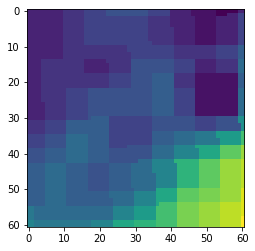

In [225]:
# cropped TPW
plt.imshow(tpw_sample[upper_row:lower_row, left_col:right_col].astype('int'))

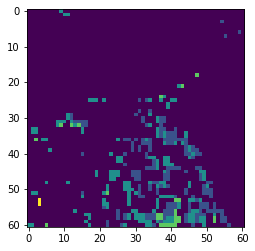

In [230]:
# cropped RR
plt.imshow(rr_sample[upper_row:lower_row, left_col:right_col].astype('int'))

### 출력 값을 열어봅니다.

In [254]:
train_output = pd.read_csv('sample_dataset/train/train_output_seomjingang.csv')
train_output.loc[train_output['관측시간']=='2020-06-25 09']

,관측소코드,관측소명,관측시간,시강수량,누가강수량,비고
50784,4001430,진안군(도통리),2020-06-25 09,0.0,401.0,NaN
50785,4001440,임실군(용암리),2020-06-25 09,0.0,406.0,NaN
50786,4001450,순창군(시산리),2020-06-25 09,0.0,521.0,NaN
50787,4003420,임실군(섬진강댐),2020-06-25 09,0.0,372.0,NaN
50788,4007450,보성군(복내리),2020-06-25 09,1.0,539.0,NaN
50789,4007470,순천시(주암댐),2020-06-25 09,0.0,548.0,NaN
50790,4007472,화순군(동가리),2020-06-25 09,0.0,484.0,NaN
50791,4007474,화순군(맹리),2020-06-25 09,0.0,574.0,NaN
50792,4009460,순천시(우산리),2020-06-25 09,0.0,509.0,NaN
50793,9000140,화순군(동복댐),2020-06-25 09,0.0,546.0,NaN


## 이제 위의 방법을 참고해 검증용 셈플 데이터를 불러와 보세요!

In [ ]:
# my code

# 정답 제출가이드

## 검증용 데이터를 이용해 샘플 정답을 채웁니다.

In [252]:
sample_output = pd.read_csv('sample_dataset/test/sample_output_seomjingang.csv')
sample_output.head(5)

,관측소코드,관측소명,관측시간,시강수량,비고
0,4001430,진안군(도통리),2020-10-01 01,0,NaN
1,4001440,임실군(용암리),2020-10-01 01,0,NaN
2,4001450,순창군(시산리),2020-10-01 01,0,NaN
3,4003420,임실군(섬진강댐),2020-10-01 01,0,NaN
4,4007450,보성군(복내리),2020-10-01 01,0,NaN


> 아래 예시는 랜덤한 값으로 sample output 의 
`시강수량`을 채운 예시입니다. </br>
> 참가자분들은 모델을 개발해 세 가지의 이미지를 입력값으로 넣고 샘플 output의 `시강수량`을 추론한 후 아래 예시처럼 정답을 저장해 제출해주세요!

In [258]:
from random import random
sample_output['시강수량'] = sample_output['시강수량'].map(lambda x: random()*5)
sample_output.to_csv('my_answer.csv')
sample_output.head(5)

왼쪽 사이드바에 파일 아이콘을 선택하여, "sample_output_seomjingang.csv" 파일을 선택하여, 파일 이름 옆 메뉴에서 다운로드를 클릭하여 파일을 다운로드 받습니다.

![img](https://github.com/aifactory-team/AFCompetition/blob/main/1896/1896_submissioin_guide_2.png?raw=true)

다운로드 받은 my_answer.csv 파일을 아래 태스크에 제출합니다. http://aifactory.space/competition/detail/1896